##### Import & Seed:

In [ ]:
# Libraries:
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import Lasso


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations
from D_CODE.run_simulation import run as run_SRT
from D_CODE.run_simulation_vi import run as run_DCODE
from toolbox.auxiliary_functions import SRT_simulation, D_CODE_simulation, set_param_freq, intercept_library_fun, bb_combinations

# Seed:
np.random.seed(999)

### Standard:

In [5]:
# Select ODE & settings:

ode_name = 'LogisticODE' # help="name of the ode", type=str
ode_param = None # help="parameters of the ode (default: None)", type=str, default=None
x_id = 0 # help="ID of the equation to be learned", type=int, default=0
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_sigma = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10

ode_param, freq = set_param_freq(ode_param, freq)

ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 1
dim_k = 0
time_vector = np.arange(0, ode.T + dt, dt)
T_SR = 10

In [3]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_sigma, dim_x, dim_k)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

# ensure existance conditions:
lb = ode.init_low 
for i in range(np.shape(X_list)[0]):
    for j in range(np.shape(X_list)[1]):
        if X_list[i][j] < 0:
            #print("negative")
            X_list[i][j] = lb
    #print(X_list[i])

# save data:
file_path = 'saved/data/logistic_data.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((X_list, dX_list, param_list, feature_names), f)

(50, 200, 1) (50, 200, 1) (0,)
['X0']


In [ ]:
# additional building blocks -> running D-CODE:

building_blocks_lambda, function_names = D_CODE_simulation(ode_name, ode_param, x_id, freq, n_sample, noise_sigma, seed=seed, n_seed=n_seed, T=T_SR)

file_path = 'saved/building_blocks/logistic_bb.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((building_blocks_lambda, function_names), f)

Running with: ode_name=LogisticODE, ode_param=None, x_id=0, freq=10, n_sample=50, noise_sigma=0.01, seed=100, n_seed=1
(101, 50, 1)
(201, 50, 1)
Dataset shape:  (201, 50, 1)
Functions set:  {'sub': 1, 'mul': 1, 'pow': 1, 'add': 1, 'neg': 1, 'div': 1, 'log': 1, 'sin': 1, 'cos': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.71      4.31351e+17       11        0.0131581        0.0102047      1.28m
   1    10.24       1.1193e+10        5       0.00928862        0.0173564      1.21m
   2     6.55      9.85142e+06        5       0.00984863        0.0123164     47.41s
 
promising programs:
sub(X0, pow(X0, 1.499))
sub(X0, pow(X0, 1.499))
sub(X0, pow(X0, 1.499))
sub(X0, pow(X0, 1.499))
sub(X0, pow(X0, 1.499))
sub(X0, pow(X0, 1.499))
sub(X0, pow(X0, 1.499))
sub(X0, pow(X0, 1.499))
sub

In [7]:
# fit and evaluate models, one for each building block:

# upload data:
file_path = 'saved/data/logistic_data.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

# upload building blocks:
file_path = 'saved/building_blocks/logistic_bb.pkl'
with open(file_path, 'rb') as f:
    building_blocks_lambda, function_names = dill.load(f)

# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)


errors = []
n_features_vec = []
for i in range(len(building_blocks_lambda)):
    # custom library with building blocks:
    custom_library = ps.CustomLibrary(library_functions=[building_blocks_lambda[i]], function_names=[function_names[i]])

    # enlarged library, adding the building block to polynomial library:
    generalized_library = ps.GeneralizedLibrary(
        libraries=[polynomial_library, custom_library],
        tensor_array=[[1, 1]] 
    )

    # add the intercept:
    final_library = ps.ConcatLibrary([intercept_library, generalized_library])

    # fitting the model:
    model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.1))
    model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)
    # Lasso: does not work :((((
    # model = ps.SINDy(feature_names=feature_names, feature_library=generalized_library, optimizer=Lasso(alpha=0.001))
    # model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)

    # library:
    # print('')
    # print('library:')
    # library_terms = final_library.get_feature_names(input_features=feature_names)
    # for term in library_terms:
    #     print(term)

    # final model:
    print('')
    print('model:')
    model.print()

    # evaluate the model:
    
    # filter too complex models (for sure not correct and likely to crash the code):
    coefficients = model.coefficients()
    lasso_penalty = np.sum(np.abs(coefficients))
    if np.count_nonzero(np.array(model.coefficients())) < 5 and lasso_penalty < 5:

        # enlarging initial range to test model robustness:
        # l = (ode.init_high - ode.init_low)/2 # print(l)
        # init_low = max(ode.init_low - l, 0)
        # init_high = ode.init_high + l #print(init_low, init_high)

        # compute MSE:
        _, mse = SINDy_data.evaluate_RMSE(model, ode, freq, 25, ode.init_high, ode.init_low, dim_k)

        # final evaluation metric:
        alpha = 0.01 # regularization parameter
        error = mse + alpha * lasso_penalty
        print('error:', error)
    else:
        error = 1000
        print('Too complex model')
    
    errors.append(error)
    n_features_vec.append(np.count_nonzero(np.array(model.coefficients())))
    print('')
    

print('errors:', errors)


model:
(X0)' = 0.997 X0 + -0.997 X0**1.499479910506444
error: 0.019941806799112567


model:
(X0)' = 0.365 X0 + -0.499 X0^2 + 0.365 X0 + -0.499 X0 X0 + 0.269 X0^2 X0
Too complex model

errors: [0.019941806799112567, 1000]


In [8]:
# Final model:
# there are many models with similar error -> we choose the simplest model (less features):

min_error = min(errors)
idxs = [i for i, e in enumerate(errors) if abs(e - min_error) < 0.1]
n_features_vec_2 = [n_features_vec[i] for i in idxs]

if len(idxs) > 1:
    print('Multiple models with similar error, choosing the simplest one')
    print('')
    idx = idxs[np.argmin(n_features_vec_2)]
else:
    idx = idxs[0]

# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

# custom library with building blocks:
custom_library = ps.CustomLibrary(library_functions=[building_blocks_lambda[idx]], function_names=[function_names[idx]])
model = ps.SINDy(feature_names=feature_names, feature_library=custom_library, optimizer=ps.STLSQ(threshold=0.01))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)
building_block = custom_library.get_feature_names(input_features=feature_names)

# enlarged library, adding building blocks to polynomial library:
generalized_library = ps.GeneralizedLibrary(
    libraries=[polynomial_library, custom_library],
    tensor_array=[[1, 1]] 
)

# add the intercept:
final_library = ps.ConcatLibrary([intercept_library, generalized_library])

# fitting the model:
model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.1))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)


# best builging block:
print('Best building block:')
print(building_block)
print('')

# final model:
print('smart-SINDy model:')
model.print()

Best building block:
['X0**1.499479910506444']

smart-SINDy model:
(X0)' = 0.997 X0 + -0.997 X0**1.499479910506444


Best Model RMSE:  0.0012747334419252907


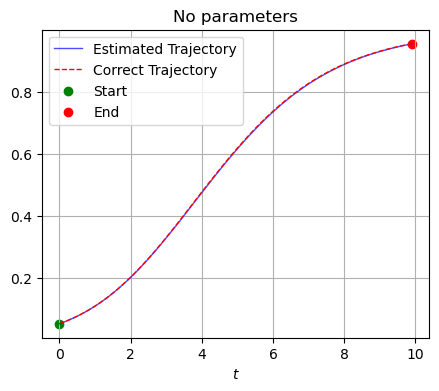

In [9]:
# evaluation
n_sample = 25
rmse_sigma, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, ode.init_high, ode.init_low, dim_k)
print('Best Model RMSE: ', rmse_sigma)

n_sample = 1
title = r'No parameters'
SINDy_data.evaluate_traj(model, ode, freq, n_sample, [0.05], [0.05], dim_x, dim_k, title=title, T_aux=10)

### Parameter $k$:

In [2]:
# Select ODE & settings:

ode_name = 'LogisticODE_k' # help="name of the ode", type=str
ode_param = None # help="parameters of the ode (default: None)", type=str, default=None
x_id = 0 # help="ID of the equation to be learned", type=int, default=0
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_sigma = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10

ode_param, freq = set_param_freq(ode_param, freq)
ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 1
dim_k = 1
time_vector = np.arange(0, ode.T + dt, dt)
T_SR = 10

In [3]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_sigma, dim_x, dim_k)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

# ensure existance conditions:
lb = ode.init_low[0] 
for i in range(np.shape(X_list)[0]):
    for j in range(np.shape(X_list)[1]):
        if X_list[i][j] < 0:
            X_list[i][j] = lb
    #print(X_list[i])

# save data:
file_path = 'saved/data/logistic_data_k.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((X_list, dX_list, param_list, feature_names), f)

(50, 200, 1) (50, 200, 1) (50, 200)
['X0', 'X1']


In [ ]:
# additional building blocks -> running D-CODE:

building_blocks_lambda, function_names = D_CODE_simulation(ode_name, ode_param, x_id, freq, n_sample, noise_sigma, seed=seed, n_seed=n_seed, T=T_SR)

file_path = 'saved/building_blocks/logistic_bb_k.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((building_blocks_lambda, function_names), f)


Running with: ode_name=LogisticODE_k, ode_param=None, x_id=0, freq=10, n_sample=50, noise_sigma=0.01, seed=100, n_seed=1
(101, 50, 2)
(201, 50, 2)
Dataset shape:  (201, 50, 2)
Functions set:  {'sub': 1, 'mul': 1, 'pow': 1, 'add': 1, 'neg': 1, 'div': 1, 'log': 1, 'sin': 1, 'cos': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.81      3.64771e+11       16         0.179245         0.142679      1.82m
   1     9.06      2.97896e+14       22         0.135341         0.130353      1.36m
   2     5.54       1.5411e+08        8        0.0299447        0.0175443     52.17s
 
promising programs:
sub(X0, pow(X0, add(1.005, X1)))
add(X0, neg(pow(X0, add(1.005, X1))))
add(X0, neg(pow(X0, add(1.005, X1))))
add(X0, neg(pow(X0, add(1.005, X1))))
add(X0, neg(pow(X0, add(1.005, X1))))
add(X0, 

In [6]:
# fit and evaluate models:

# upload data:
file_path = 'saved/data/logistic_data_k.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

# upload building blocks:
file_path = 'saved/building_blocks/logistic_bb_k.pkl'
with open(file_path, 'rb') as f:
    building_blocks_lambda, function_names = dill.load(f)


# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

errors = []
n_features_vec = []
for i in range(len(building_blocks_lambda)):

    # custom library with building blocks:
    custom_library = ps.CustomLibrary(library_functions=[building_blocks_lambda[i]], function_names=[function_names[i]])

    # enlarged library, adding the building block to polynomial library:
    generalized_library = ps.GeneralizedLibrary(
        libraries=[polynomial_library, custom_library],
        tensor_array=[[1, 1]] 
    )

    # add the intercept:
    final_library = ps.ConcatLibrary([intercept_library, generalized_library])

    # fitting the model: Sequentially thresholded least squares:
    model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.1))
    model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)

    # library:
    # print('')
    # print('library:')
    # library_terms = final_library.get_feature_names(input_features=feature_names)
    # for term in library_terms:
    #     print(term)

    # final model:
    print('')
    print('model:')
    model.print()

    # evaluate the model:

    # filter too complex models (for sure not correct and likely to crash the code):
    coefficients = model.coefficients()
    lasso_penalty = np.sum(np.abs(coefficients))
    if np.count_nonzero(np.array(model.coefficients())) < 5 and lasso_penalty < 5:

        # compute MSE:
        _, mse = SINDy_data.evaluate_RMSE(model, ode, freq, 10, ode.init_high, ode.init_low, dim_k)
        
        # final evaluation metric:
        alpha = 0.01 # regularization parameter
        error = mse + alpha * lasso_penalty
        print('error:', error)
    else:
        error = 1000
        print('')
        print('Too complex model')
    
    errors.append(error)
    n_features_vec.append(np.count_nonzero(np.array(model.coefficients())))
    print('')
    

print('errors:', errors)


model:
(X0)' = 0.993 X0 + -0.993 X0**(X1 + 1.0049298055821259)
error: 0.019870757433016896


model:
(X0)' = 0.519 X0 + 0.246 X0^2 + 0.585 X0 X1 + -0.821 X0**1.5593542983340385 + 0.055 X0^2 X0**1.5593542983340385 + -0.583 X0 X1 X0**1.5593542983340385

Too complex model


model:
(X0)' = 1.214 X0 sin(X1) + -1.213 X0^2 sin(X1)
error: 0.0371966025034008


model:
(X0)' = 0.517 X0 + 0.766 X0^2 + 0.553 X0 X1 + -1.349 X0**1.726649547300216 + 0.066 X0^2 X0**1.726649547300216 + -0.552 X0 X1 X0**1.726649547300216

Too complex model


model:
(X0)' = 44176381799.279 X0 X1 + -44176381798.320 X1 X0 + -0.959 X0 X1 X0

Too complex model

errors: [0.019870757433016896, 1000, 0.0371966025034008, 1000, 1000]


In [7]:
# Final model:

min_error = min(errors)
idxs = [i for i, e in enumerate(errors) if abs(e - min_error) < 0.1]
n_features_vec_2 = [n_features_vec[i] for i in idxs]

if len(idxs) > 1:
    print('Multiple models with similar error, choosing the simplest one')
    print('')
    idx = idxs[np.argmin(n_features_vec_2)]
else:
    idx = idxs[0]


# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

# custom library with building blocks:
custom_library = ps.CustomLibrary(library_functions=[building_blocks_lambda[idx]], function_names=[function_names[idx]])
model = ps.SINDy(feature_names=feature_names, feature_library=custom_library, optimizer=ps.STLSQ(threshold=0.01))
model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
building_block = custom_library.get_feature_names(input_features=feature_names)

# enlarged library, adding building blocks to polynomial library:
generalized_library = ps.GeneralizedLibrary(
    libraries=[polynomial_library, custom_library],
    tensor_array=[[1, 1]] 
)

# add the intercept:
final_library = ps.ConcatLibrary([intercept_library, generalized_library])

# fitting the model:
model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.1))
model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)


# best builging block:
print('Best building block:')
print(building_block)
print('')

# final model:
print('smart_SINDy model:')
model.print()

Multiple models with similar error, choosing the simplest one

Best building block:
['X0**(X1 + 1.0049298055821259)']

smart_SINDy model:
(X0)' = 0.993 X0 + -0.993 X0**(X1 + 1.0049298055821259)


Best Model RMSE:  0.0015616808098870769


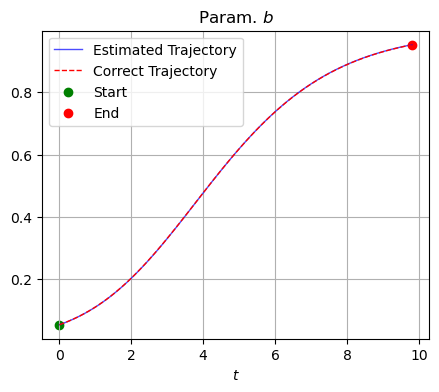

In [8]:
# evaluation
n_sample = 25
rmse_sigma, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, ode.init_high, ode.init_low, dim_k)
print('Best Model RMSE: ', rmse_sigma)

n_sample = 1
title = r'Param. $b$'
SINDy_data.evaluate_traj(model, ode, freq, n_sample, [0.05, 0.5], [0.05, 0.5], dim_x, dim_k, title=title, T_aux=10)

Best Model RMSE:  0.001929642503485927


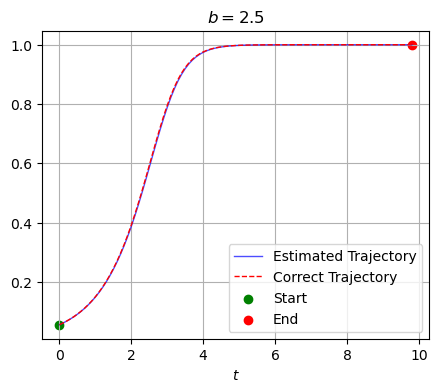

In [9]:
# testing robustness:
init_point = [0.05, 2.5]
n_sample = 3
rmse_ab_1, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, init_point, init_point, dim_k)
print('Best Model RMSE: ', rmse_ab_1)
n_sample = 1
title = r'$b = 2.5$'
SINDy_data.evaluate_traj(model, ode, freq, n_sample, init_point, init_point, dim_x, dim_k, title=title, T_aux=10)

### Parameter $a$:

In [2]:
# Select ODE & settings:

ode_name = 'LogisticODE_a' # help="name of the ode", type=str
ode_param = None # help="parameters of the ode (default: None)", type=str, default=None
x_id = 0 # help="ID of the equation to be learned", type=int, default=0
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_sigma = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10

ode_param, freq = set_param_freq(ode_param, freq)
ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 1
dim_k = 1
time_vector = np.arange(0, ode.T + dt, dt)
T_SR = 10

In [3]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_sigma, dim_x, dim_k)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

# ensure existance conditions:
lb = ode.init_low[0] 
for i in range(np.shape(X_list)[0]):
    for j in range(np.shape(X_list)[1]):
        if X_list[i][j] < 0:
            X_list[i][j] = lb
    #print(X_list[i])

# save data:
file_path = 'saved/data/logistic_data_a.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((X_list, dX_list, param_list, feature_names), f)

(50, 200, 1) (50, 200, 1) (50, 200)
['X0', 'X1']


In [ ]:
# additional building blocks -> running D-CODE:

building_blocks_lambda, function_names = D_CODE_simulation(ode_name, ode_param, x_id, freq, n_sample, noise_sigma, seed=seed, n_seed=n_seed, T=T_SR)

file_path = 'saved/building_blocks/logistic_bb_a.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((building_blocks_lambda, function_names), f)

Running with: ode_name=LogisticODE_a, ode_param=None, x_id=0, freq=10, n_sample=50, noise_sigma=0.01, seed=100, n_seed=1
(101, 50, 2)
(201, 50, 2)
Dataset shape:  (201, 50, 2)
Functions set:  {'sub': 1, 'mul': 1, 'pow': 1, 'add': 1, 'neg': 1, 'div': 1, 'log': 1, 'sin': 1, 'cos': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.79       7.7003e+11        5        0.0771895        0.0792846      1.66m
   1     8.82      3.17502e+10        5        0.0698516         0.145325      1.13m
   2     5.65       3.3147e+06       11        0.0476801        0.0518134     49.16s
 
promising programs:
mul(sub(X0, pow(X0, 1.559)), X1)
mul(sin(sub(X0, pow(X0, 1.559))), X1)
mul(sin(sub(X0, pow(X0, 1.559))), X1)
sub(X0, pow(X0, 1.559))
sub(X0, pow(X0, 1.559))
sub(X0, pow(X0, 1.559))
sub(X0, pow(

In [7]:
# fit and evaluate models:

# upload data:
file_path = 'saved/data/logistic_data_a.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

# upload building blocks:
file_path = 'saved/building_blocks/logistic_bb_a.pkl'
with open(file_path, 'rb') as f:
    building_blocks_lambda, function_names = dill.load(f)

# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

errors = []
n_features_vec = []
for i in range(len(building_blocks_lambda)):

    # custom library with building blocks:
    custom_library = ps.CustomLibrary(library_functions=[building_blocks_lambda[i]], function_names=[function_names[i]])

    # enlarged library, adding the building block to polynomial library:
    generalized_library = ps.GeneralizedLibrary(
        libraries=[polynomial_library, custom_library],
        tensor_array=[[1, 1]] 
    )

    # add the intercept:
    final_library = ps.ConcatLibrary([intercept_library, generalized_library])

    # fitting the model: Sequentially thresholded least squares:
    model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.1))
    model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)

    # library:
    # print('')
    # print('library:')
    # library_terms = final_library.get_feature_names(input_features=feature_names)
    # for term in library_terms:
    #     print(term)

    # final model:
    print('')
    print('model:')
    model.print()

    # evaluate the model:

    # filter too complex models (for sure not correct and likely to crash the code):
    coefficients = model.coefficients()
    lasso_penalty = np.sum(np.abs(coefficients))
    if np.count_nonzero(np.array(model.coefficients())) < 5 and lasso_penalty < 5:

        # enlarging initial range to test model robustness:
        # l = (ode.init_high - ode.init_low)/2 # print(l)
        # init_low = max(ode.init_low - l, 0)
        # init_high = ode.init_high + l #print(init_low, init_high)

        # compute MSE:
        _, mse = SINDy_data.evaluate_RMSE(model, ode, freq, 10, ode.init_high, ode.init_low, dim_k)

        # final evaluation metric:
        alpha = 0.01 # regularization parameter
        error = mse + alpha * lasso_penalty
        print('error:', error)
    else:
        error = 1000
        print('Too complex model')
    
    errors.append(error)
    n_features_vec.append(np.count_nonzero(np.array(model.coefficients())))
    print('')
    

print('errors:', errors)



model:
(X0)' = 0.915 X0 X1 + -0.915 X1 X0**1.5593542983340385
error: 0.018425171107763396


model:
(X0)' = 0.917 X1 sin(X0 - X0**1.5593542983340385)
error: 0.009292718460629148


model:
(X0)' = 364096646303.485 X0 X1 + -364096646302.889 X0 X1 + -0.599 X0^2 X1
Too complex model


model:
(X0)' = 0.981 X1 sin(X0 - X0**1.5142520823349135) + -0.001 X1^2 sin(X0 - X0**1.5142520823349135)
error: 0.00982788063389769

errors: [0.018425171107763396, 0.009292718460629148, 1000, 0.00982788063389769]


In [8]:
# Final model:

min_error = min(errors)
idxs = [i for i, e in enumerate(errors) if abs(e - min_error) < 0.1]
n_features_vec_2 = [n_features_vec[i] for i in idxs]

if len(idxs) > 1:
    print('Multiple models with similar error, choosing the simplest one')
    print('')
    idx = idxs[np.argmin(n_features_vec_2)]
else:
    idx = idxs[0]

# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

# custom library with building blocks:
custom_library = ps.CustomLibrary(library_functions=[building_blocks_lambda[idx]], function_names=[function_names[idx]])
model = ps.SINDy(feature_names=feature_names, feature_library=custom_library, optimizer=ps.STLSQ(threshold=0.01))
model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
building_block = custom_library.get_feature_names(input_features=feature_names)

# enlarged library, adding building blocks to polynomial library:
generalized_library = ps.GeneralizedLibrary(
    libraries=[polynomial_library, custom_library],
    tensor_array=[[1, 1]] 
)

# add the intercept:
final_library = ps.ConcatLibrary([intercept_library, generalized_library])

# fitting the model:
model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.1))
model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)


# best builging block:
print('Best building block:')
print(building_block)
print('')

# final model:
print('smart-SINDy model:')
model.print()

Multiple models with similar error, choosing the simplest one

Best building block:
['X0**1.5593542983340385']

smart-SINDy model:
(X0)' = 0.915 X0 X1 + -0.915 X1 X0**1.5593542983340385


Best Model RMSE:  0.008685610463522283


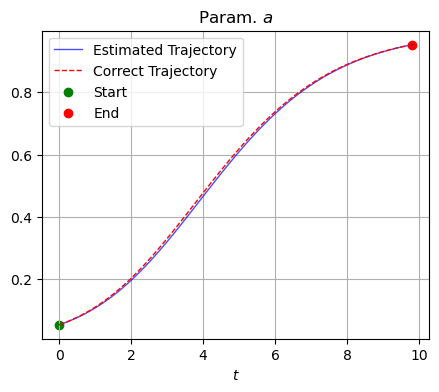

In [ ]:
# evaluation
n_sample = 25
rmse_sigma, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, ode.init_high, ode.init_low, dim_k)
print('Best Model RMSE: ', rmse_sigma)

n_sample = 1
title = r'Param. $a$'
SINDy_data.evaluate_traj(model, ode, freq, n_sample, [0.05, 1.], [0.05, 1.], dim_x, dim_k, title=title, T_aux=10)

RMK. il modello sinusoidale è equivalente al modello corretto, trovato anch'esso, per x->0 
=> per smascherare quale dei due è il modello corretto bisogna aumentare x allontanandosi da 0